# Creating a NeuralNetwork from scratch
> A tutorial to code a neural network from scratch in python using numpy.

- toc: false
- badges: true
- comments: true
- categories: [deeplearning python3.x numpy]
- image: images/backprop.jpeg

I will assume that you all know what a artificial neural network is and have a little bit of knowledge about `forward and backward propagation`. Just having a simple idea is enough.

> Tip: If you do not know what the above terms are or would like to brush up on the topics, I would suggest going through this amazing [youtube playlist](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) by [3Blue1Brown](https://www.3blue1brown.com/).

> youtube: https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

## Setting up Imports:

In [1]:
import numpy as np
import gzip
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import warnings


np.random.seed(123)
%matplotlib inline
warnings.filterwarnings("ignore")

## Preparing the data

For this blog post, we'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database). MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

Run the code given below to download the `MNIST` dataset.

```shell
wget -P path http://deeplearning.net/data/mnist/mnist.pkl.gz
```

> Note: the above code snippet will download the dataset to `{path}` so be sure to set the `{path}` to the desired location of your choice. 

In [2]:
def get_data(path):
    """
    Fn to unzip the MNIST data and return
    the data as numpy arrays
    """
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(np.array, (x_train,y_train,x_valid,y_valid))


# Grab the MNIST dataset
x_train,y_train,x_valid,y_valid = get_data(path= "../../Datasets/mnist.pkl.gz")

tots,feats = x_train.shape
print("Shape of x_train:",x_train.shape)
print("Total number of examples:", tots)
print("Number of pixel values per image:", feats)

Shape of x_train: (50000, 784)
Total number of examples: 50000
Number of pixel values per image: 784


## Preparing our `train` & `validation` datasets

To make our life a bit easier we are going to take only the examples that contain a 1 or 0.

In [3]:
zero_mask = [y_train==0] # grab all the index values where 0 is present
one_mask = [y_train==1] # grad all the index valus where 1 is present

# grab all the 1's and 0's and make training set
x_train = np.vstack((x_train[zero_mask], x_train[one_mask]))
y_train = np.reshape(y_train, (-1,1))
y_train = np.squeeze(np.vstack((y_train[zero_mask], y_train[one_mask]))).reshape(-1,1)

x_train.shape, y_train.shape

((10610, 784), (10610, 1))

**Our training set now has 10610 examples**

In [4]:
zero_mask = [y_valid==0] # grab all the index values where 0 is present
one_mask = [y_valid==1] # grad all the index valus where 1 is present

# grab all the 1's and 0's and make training set
x_valid = np.vstack((x_valid[zero_mask], x_valid[one_mask]))
y_valid = np.reshape(y_valid, (-1,1))
y_valid = np.squeeze(np.vstack((y_valid[zero_mask], y_valid[one_mask]))).reshape(-1,1)

x_valid.shape, y_valid.shape

((2055, 784), (2055, 1))

**Our validation set now has 2055 examples**

**Why do we need different training and validation sets ?**

Since, this topic requires a different post on it's own I won't be covering it here. But you can get the idea from this above video:

> youtube: https://youtu.be/1waHlpKiNyY?t=243

Let's view some example images from our dataset:

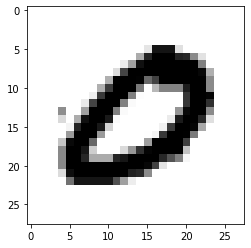

In [7]:
#collapse 
plt.imshow(x_train[50].reshape(28,28), cmap="binary");

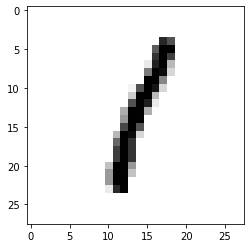

In [8]:
#collapse
plt.imshow(x_train[5000].reshape(28,28), cmap="binary");

## Basic Model Architecture

For this task we are going to use a very basic model architecture this 2 linear layers and a output layer with 1 unit.

In [9]:
#hide_input 
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

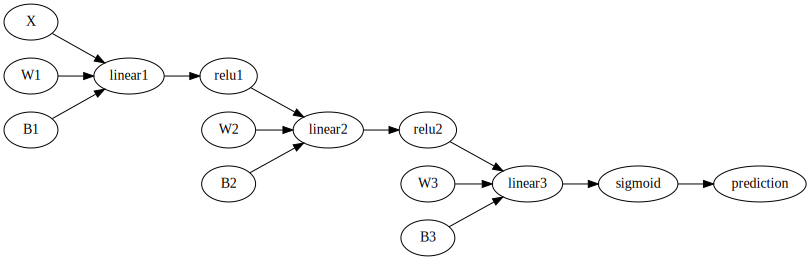

In [10]:
#hide_input
gv('''
X->linear1->relu1->linear2->relu2->linear3->sigmoid->prediction

W1->linear1
B1->linear1

W2->linear2
B2->linear2

W3->linear3
B3->linear3
''')

and then using the `predicted` value from the above model and the `real_target` value the loss is calculated:

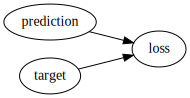

In [11]:
#hide_input
gv('''
prediction->loss
target->loss
''')

## Let's take a deep dive into what this network means:

Let's take at look at all the individual components of this network:
- **Linear:**
  The linear layer computes the following :      
   ```
   out = matmul(input,W1) + B1
   ```
   
- **ReLU:** 
  The relu computes the following:
  ```
  out = max(0, input)
  ```
- **Sigmoid:** 
  The sigmoid computes the following:
  ```
  out = 1/(1 + e.pow(input))
  ```
  
- **Loss:** 
  For the loss we are going to use the CrossEntropy Loss which is defined by the follwoing equation:
  $$loss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) $$

**Now that we have our model architecture, let's create the different parts needed to assemble the model:**
- linear layer
- relu activation
- sigmoid activation
- loss

**Let's first try to make some sense of what is happening in the backward and forward pass of our model:**

**On paper our forward pass would look something like this:**

> Note: `@` in python is the `matrix-multiplication operator`. 

```python
inputs = x # original inputs
targets = y # original targets

z1 = inputs @ w2 + b2
a1 = relu(z1)

z2 = a1 @ w2 + b2
a2 = sigmoid(z2) # this is our model prediction

loss = loss_fn(a2, targets)
```
> Note: This is not actual code it's just psuedo-code for understanding.

**Consequently our backward pass would look something like this :** 

(Let us assume that the `grad(inp, out)` computes the gradients of `inp` wrt `out`)

```python
# gradient of loss wrt output of the previous activation layer
da2 = grad(loss, a2) 

# gradient of loss wrt to z2
dz2 = grad(loss, z2) = grad(loss, a2) * grad(a2,z2) 

# gradient of the loss wrt to weight w2: [current layer]
dw2 = grad(loss, w2) = grad(loss, z2) * grad(z2, w2) = dz2 * grad(z2, w2)
# gradient of the loss wrt to bias b2: [current layer]
db2 = grad(loss, b2) = grad(loss, z2) * grad(z2, b2) = dz2 * grad(z2, b2)
# gradient of loss wrt a1: [previous layer]
da1 = grad(loss, a1) = grad(loss, z2) * grad(z2, a1) = dz2 * grad(z2, a1)

# gradient of loss wrt z1
dz1 = grad(loss, z1) = grad(loss, a1) * grad(a1, z1) = da1 * grad(a1, z1)

# gradient of the loss wrt to weight w1: [current layer]
dw1 = grad(loss, w1) = grad(loss, z1) * grad(z1, w1) = dz1 * grad(z1, w1)
# gradient of the loss wrt to bias b1: [current layer]
db1 = grad(loss, b1) = grad(loss, z1) * grad(z1, b1) = dz1 * grad(z1, b1)
# gradient of the loss wrt to a0: [previous layer]
da0 = grad(loss, a0) = grad(loss, z1) * grad(z1, a0) = dz2 * grad(z1, a0)


# Update parameters :
# since we now have all the required gradients we can now perform the update step
w1 -= learning_rate * dw1
b1 -= learning_rate * db1

w2 -= learning_rate * dw2
b2 -= learning_rate * db2
```
> Note: This is not actual code it's just psuedo-code for understanding.

### `linear` layer 

Below code creates a `Linear class` which represents a `Linear` layer in our neural-network. The `forward function` of the class implements the of the `layer's forward propagation` & the `backward function` implements the `layers's backward propagation`. Let's go to detail into what the code means:

- **Forward:**  
This part is quite straight-forward it computes the dot-product between the **`input`** and the **`weights`** & adds the **`bias`** term to get **`z`**. It also stores all the intermidiate values generated to use in the backward pass.


- **Backward:**
    * The backward method of the class **`Linear`** takes in the argument **`grads`**. 
    * **`grads`** is the gradient of the loss wrt to the output of the current linear layer ie., **`dz`** if we were to follow the nomenclature of our pseudo-code.
    * To succesfully compute the backward pass for our linear layer we need the following:
        - **`grad(z, w)`** 
        - **`grad(z, b)`**
        - **`grad(z, a_prev)`**



> Note: `z`, `w`, `b`, `a_prev` are the outputs, weights, bias and input-activations of the Linear layer respectively.

In [12]:
class Linear:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def forward(self, inp):
        """
        Implement the linear part of a layer's forward propagation.
        
        Args:
            inp : activations from previous layer (or input data)
        
        Returns:

            z  : the input of the activation function, also called pre-activation parameter 
        """
        self.inp = inp
        self.z   = inp @ self.w + self.b
        return self.z
    
    def backward(self, grads):
        """
        Implement the linear portion of backward propagation for a single layer.

        Args:
            grads :  Gradient of the cost with respect to the linear output. 
                     or the accumulated gradients from the prev layers. 
                     This is used for the chain rule to compute the gradients.
        Returns:
            da : Gradient of cost wrt to the activation of the previous layer or the input of the 
                 current layer.
            dw : Gradient of the cost with respect to W
            db : Gradient of the cost with respect to b
        """
        m = self.inp.shape[1]
        # gradient of loss wrt to the weights
        dw = 1/m * (self.inp.T @ grads)
        # gradient of the loss wrt to the bias
        db = 1/m * np.sum(grads, axis=0, keepdims=True)
        # gradient of the loss wrt to the input of the linear layer
        # this is used to continue the chain rule
        da_prev = grads @ self.w.T 
        return (da_prev, dw, db)

### `ReLU` layer

- **Forward**:  
The mathematical formula for ReLU is $A = RELU(Z) = max(0, Z)$
- **Backward**:  
During the backward pass the relu accepts the gradients of the `loss wrt to the activation` i.e, `da` then computes
the gradients of the `loss wrt to the input-of-relu(z)` i.e, `dz`.

In [13]:
class RelU:
    def forward(self, inp):
        """
        Implement the RELU function.

        Args:
            inp : Output of the linear layer, of any shape

        Returns:
            a  : Post-activation parameter, of the same shape as Z
        """
        self.inp = inp
        self.output = np.maximum(0, self.inp)
        return self.output
    
    def backward(self, grads):
        """
        Implement the backward propagation for a single RELU unit.

        Ars:
            grads : gradients of the loss wrt to the activation output

        Returns:
            dz : Gradient of the loss with respect to the input of the activation
        """
        dz = np.array(grads, copy=True)
        dz[self.inp <= 0] = 0
        return dz

### `sigmoid` layer

The sigmoid layer functions in exactly the same way as the `ReLU` layer . The only difference is the forward pass output calculation. 


In the `sigmoid layer`:  $\sigma(Z) = \frac{1}{ 1 + e^{-(W A + b)}}$

In [14]:
class Sigmoid:
    def forward(self, inp):
        """
        Implements the sigmoid activation in numpy

        Args:
            inp: numpy array of any shape

        Returns:
            a  : output of sigmoid(z), same shape as inp
        """
        self.inp = inp
        self.out =  1/(1+np.exp(-self.inp))
        return self.out
    
    def backward(self, grads):
        """
        Implement the backward propagation for a single sigmoid unit.

        Args:
            grads : gradients of the loss wrt to the activation output

        Returns:
            dz : Gradient of the loss with respect to the input of the activation
        """
        s = 1/(1+np.exp(-self.inp))
        dz = grads * s * (1-s)
        return dz

## Loss_function :

For this task we are going to use the [CrossEntropy Loss](https://en.wikipedia.org/wiki/Cross_entropy)

The `forward` pass of the CrossEntropy Loss is computed as follows: 
$$loss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) $$

In [15]:
class CELoss():
    def forward(self, pred, target):
        """
        Implement the CrossEntropy loss function.

        Args:
            pred   : predicted labels from the neural network
            target : true "label" labels
        Returns:
            loss : cross-entropy loss
        """
        self.yhat = pred
        self.y = target
        m = self.y.shape[0]
        # commpute loss
        term1 = (np.multiply(self.y, np.log(self.yhat)))
        term2 = (np.multiply((1-self.y),(np.log(1-self.yhat))))
        loss = -1/m * np.sum(term1+term2)
        self.output = loss
        return np.squeeze(self.output) # convert array to a single value number
    
    def backward(self):
        """
        Computes the gradinets of the loss_fn wrt to the predicted labels
        
        Returns:
         da : derivative of loss_fn wrt to the predicted labels
        """
        # derivative of loss_fn with respect to a [predicted labels]
        da = - (np.divide(self.y, self.yhat) - np.divide(1 - self.y, 1 - self.yhat)) 
        return da

## Model:

**Let's go over the architecture that we are going to use for our neural netwok:**

Our model is going to have 2 hidden layers and a output layer. The `hidden layers` are going to have `16 units` each followed by a `ReLU` activation layer and the `output layer` is going to have `1 unit` followed by a `Sigmoid` unit. The ouput layer is going to predict the `input` is either `0` or `1`. 

Let's assemble the layers required to construct out model:

In [16]:
# these are our inputs and targets
x_train.shape, y_train.shape

((10610, 784), (10610, 1))

In [17]:
nh1 = 16 # no. of units in the first hidden layer
nh2 = 16 # no. of units in the 2nd hidden layer
nh3 = 1 # no. of units in the output layer

w1  = np.random.randn(x_train.shape[1], nh1) * 0.01
b1  = np.zeros((1, nh1))

w2  = np.random.randn(nh1, nh2) * 0.01
b2  = np.zeros((1, nh2))

w3  = np.random.randn(nh2, nh3)
b3  = np.zeros((1, nh3))

w1.shape, b1.shape, w2.shape, b2.shape, w3.shape, b3.shape

((784, 16), (1, 16), (16, 16), (1, 16), (16, 1), (1, 1))

In [18]:
# instaniating the layers needed to construct our model

lin1 = Linear(w1,b1) # 1 hidden layer
relu1 = RelU()
lin2 = Linear(w2,b2) # 2nd hidden layer
relu2 = RelU()
lin3 = Linear(w3,b3) # output layer
sigmoid = Sigmoid()

loss_fn = CELoss() # loss_fn

### Forward pass:

In [19]:
# forward pass
z1 = lin1.forward(x_train)
a1 = relu1.forward(z1)
z2 = lin2.forward(a1)
a2 = relu2.forward(z2)
z3 = lin3.forward(a2)
pred = sigmoid.forward(z3)

# calculate loss
loss = loss_fn.forward(pred, y_train)
print("Loss:", loss) # print out the loss

Loss: 0.6954586218304929


In [20]:
print("Predictions: ", pred)

Predictions:  [[0.50221048]
 [0.5016568 ]
 [0.50445   ]
 ...
 [0.5006608 ]
 [0.49939964]
 [0.49894181]]


### Backward pass:

In [21]:
# backward pass
da3 = sigmoid.backward(loss_fn.backward())
dz3, dw3, db3 = lin3.backward(da3)

da2 = relu2.backward(dz3)
dz2, dw2, db2 = lin2.backward(da2)

da1 = relu1.backward(dz2)
_, dw1, db1 = lin1.backward(da1)

### Update parameters:

In [22]:
# set learning rate
learning_rate = 0.0002

# update parameters 
lin1.w -= learning_rate * dw1
lin2.w -= learning_rate * dw2
lin3.w -= learning_rate * dw3

lin1.b -= learning_rate * db1
lin2.b -= learning_rate * db2
lin3.b -= learning_rate * db3

### Putting it all together:

In [48]:
# Instantiate parameters

nh1 = 16 # no. of units in the first hidden layer
nh2 = 16 # no. of units in the 2nd hidden layer
nh3 = 1 # no. of units in the output layer

w1  = np.random.randn(x_train.shape[1], nh1) * 0.01
b1  = np.zeros((1, nh1))

w2  = np.random.randn(nh1, nh2) * 0.01
b2  = np.zeros((1, nh2))

w3  = np.random.randn(nh2, nh3)
b3  = np.zeros((1, nh3))

print(w1.shape, b1.shape, w2.shape, b2.shape, w3.shape, b3.shape)

(784, 16) (1, 16) (16, 16) (1, 16) (16, 1) (1, 1)


In [49]:
class Model:
    def __init__(self, learning_rate):
        """
        A simple neural network model
        The `forward` method computes the forward propagation step of the model
        The `backward` method computes the backward step propagation of the model
        The `update_step` method updates the parameters of the model
        """
        self.lin1    = Linear(w1,b1)
        self.relu1   = RelU()
        self.lin2    = Linear(w2,b2)
        self.relu2   = RelU()
        self.lin3    = Linear(w3,b3)
        self.sigmoid = Sigmoid()
        self.loss_fn = CELoss()
        self.lr      = learning_rate
        self.losses  = [] # stores the loss at each iteration


    def forward(self, inp, calc_loss=True):
        """
        Computs the forward step for out model
        Returns the loss and the prediction of the model
        """
        out  = self.relu1.forward(self.lin1.forward(inp))
        out  = self.relu2.forward(self.lin2.forward(out))
        pred = self.sigmoid.forward(self.lin3.forward(out))
        
        if calc_loss:
            loss = self.loss_fn.forward(pred, y_train)
            # appending the loss of the current iteration
            self.losses.append(loss)
            return loss, pred
        else:
            return pred


    def backward(self):
        """
        Computes the backward step
        and return the gradients of the parameters with the loss
        """
        da3 = self.sigmoid.backward(self.loss_fn.backward())
        dz3, dw3, db3 = self.lin3.backward(da3)

        da2 = self.relu2.backward(dz3)
        dz2, dw2, db2 = self.lin2.backward(da2)

        da1 = self.relu1.backward(dz2)
        _, dw1, db1 = self.lin1.backward(da1)

        self.dws = [dw1, dw2, dw3]
        self.dbs = [db1, db2, db3]


    def update_step(self):
        """
        Performs the update step
        """
        self.lin1.w -= self.lr * self.dws[0]
        self.lin2.w -= self.lr * self.dws[1]
        self.lin3.w -= self.lr * self.dws[2]

        self.lin1.b -= self.lr * self.dbs[0]
        self.lin2.b -= self.lr * self.dbs[1]
        self.lin3.b -= self.lr * self.dbs[2]

In [50]:
nn = Model(learning_rate=0.0005)
epochs = 50 # no. of iterations to train

for n in range(epochs):
    loss, _ = nn.forward(x_train)
    nn.backward()
    nn.update_step()
    print(f"Loss after interation {n} is {loss:.4f}")

Loss after interation 0 is 0.6935
Loss after interation 1 is 0.6829
Loss after interation 2 is 0.6675
Loss after interation 3 is 0.6481
Loss after interation 4 is 0.6228
Loss after interation 5 is 0.5924
Loss after interation 6 is 0.5488
Loss after interation 7 is 0.5149
Loss after interation 8 is 0.4527
Loss after interation 9 is 0.3746
Loss after interation 10 is 0.3095
Loss after interation 11 is 0.2433
Loss after interation 12 is 0.2016
Loss after interation 13 is 0.1698
Loss after interation 14 is 0.1448
Loss after interation 15 is 0.1250
Loss after interation 16 is 0.1091
Loss after interation 17 is 0.0963
Loss after interation 18 is 0.0859
Loss after interation 19 is 0.0773
Loss after interation 20 is 0.0702
Loss after interation 21 is 0.0641
Loss after interation 22 is 0.0590
Loss after interation 23 is 0.0546
Loss after interation 24 is 0.0509
Loss after interation 25 is 0.0476
Loss after interation 26 is 0.0447
Loss after interation 27 is 0.0421
Loss after interation 28 is 0.

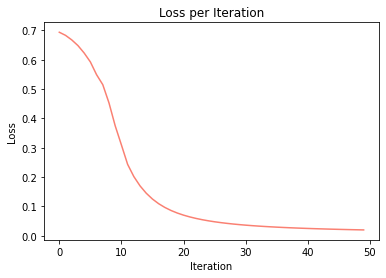

In [51]:
#collapse
plt.plot(nn.losses, color="salmon")
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss");

## Computing accuracy of our model

**Let's check our model performance by computing the `accuracy` on the `validation` dataset**

In [54]:
def comp_accuracy(preds, targs):
    """
    Fn that computes the accuracy between the predicted values and the targets
    """
    m = len(targs)
    p = np.zeros_like(preds)
    # convert probas to 0/1 predictions
    for i in range(len(preds)):
        if preds[i] > 0.5:
            p[i] = 1
        else:
            p[i] = 0
    print("Accuracy: "  + str(np.sum((p == targs)/m)))    

In [55]:
# generate predicitons from out model
preds = nn.forward(x_valid, calc_loss=False)
# compute accuracy
comp_accuracy(preds, y_valid)

Accuracy: 0.9965936739659367


> Note: Nice our model achieves a `accuracy` of **`0.9965936739659367`** on the validation set !

## Getting predictions from our model

Predicted output: 0


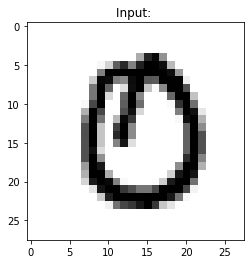

In [66]:
#collapse
test_inp = x_valid[0]
plt.title("Input: ")
plt.imshow(test_inp.reshape(28,28), cmap="binary");

loss, pred = nn.forward(test_inp)
predicted_val = int(pred > 0.5)
print(f"Predicted output: {predicted_val}")

Predicted output: 1


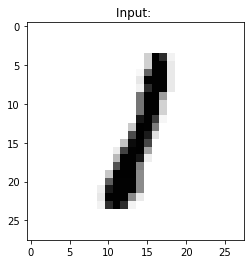

In [67]:
#collapse
test_inp = x_valid[2000]
plt.title("Input: ")
plt.imshow(test_inp.reshape(28,28), cmap="binary");

loss, pred = nn.forward(test_inp)
predicted_val = int(pred > 0.5)
print(f"Predicted output: {predicted_val}")

## Summary:

- We were able to create a model that can identify classify handwritten digits as either 1's or 0's
- We successfully computed the `forward` and `backward` progation of a `neural network` from scratch.

**Thanks for reading !**